# Lab 4 Report: 
## Surpass Human Performance in Fashion MNIST Classificaion

### Name:

In [219]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import numpy as np

In [220]:
from IPython.display import Image # For displaying images in colab jupyter cell

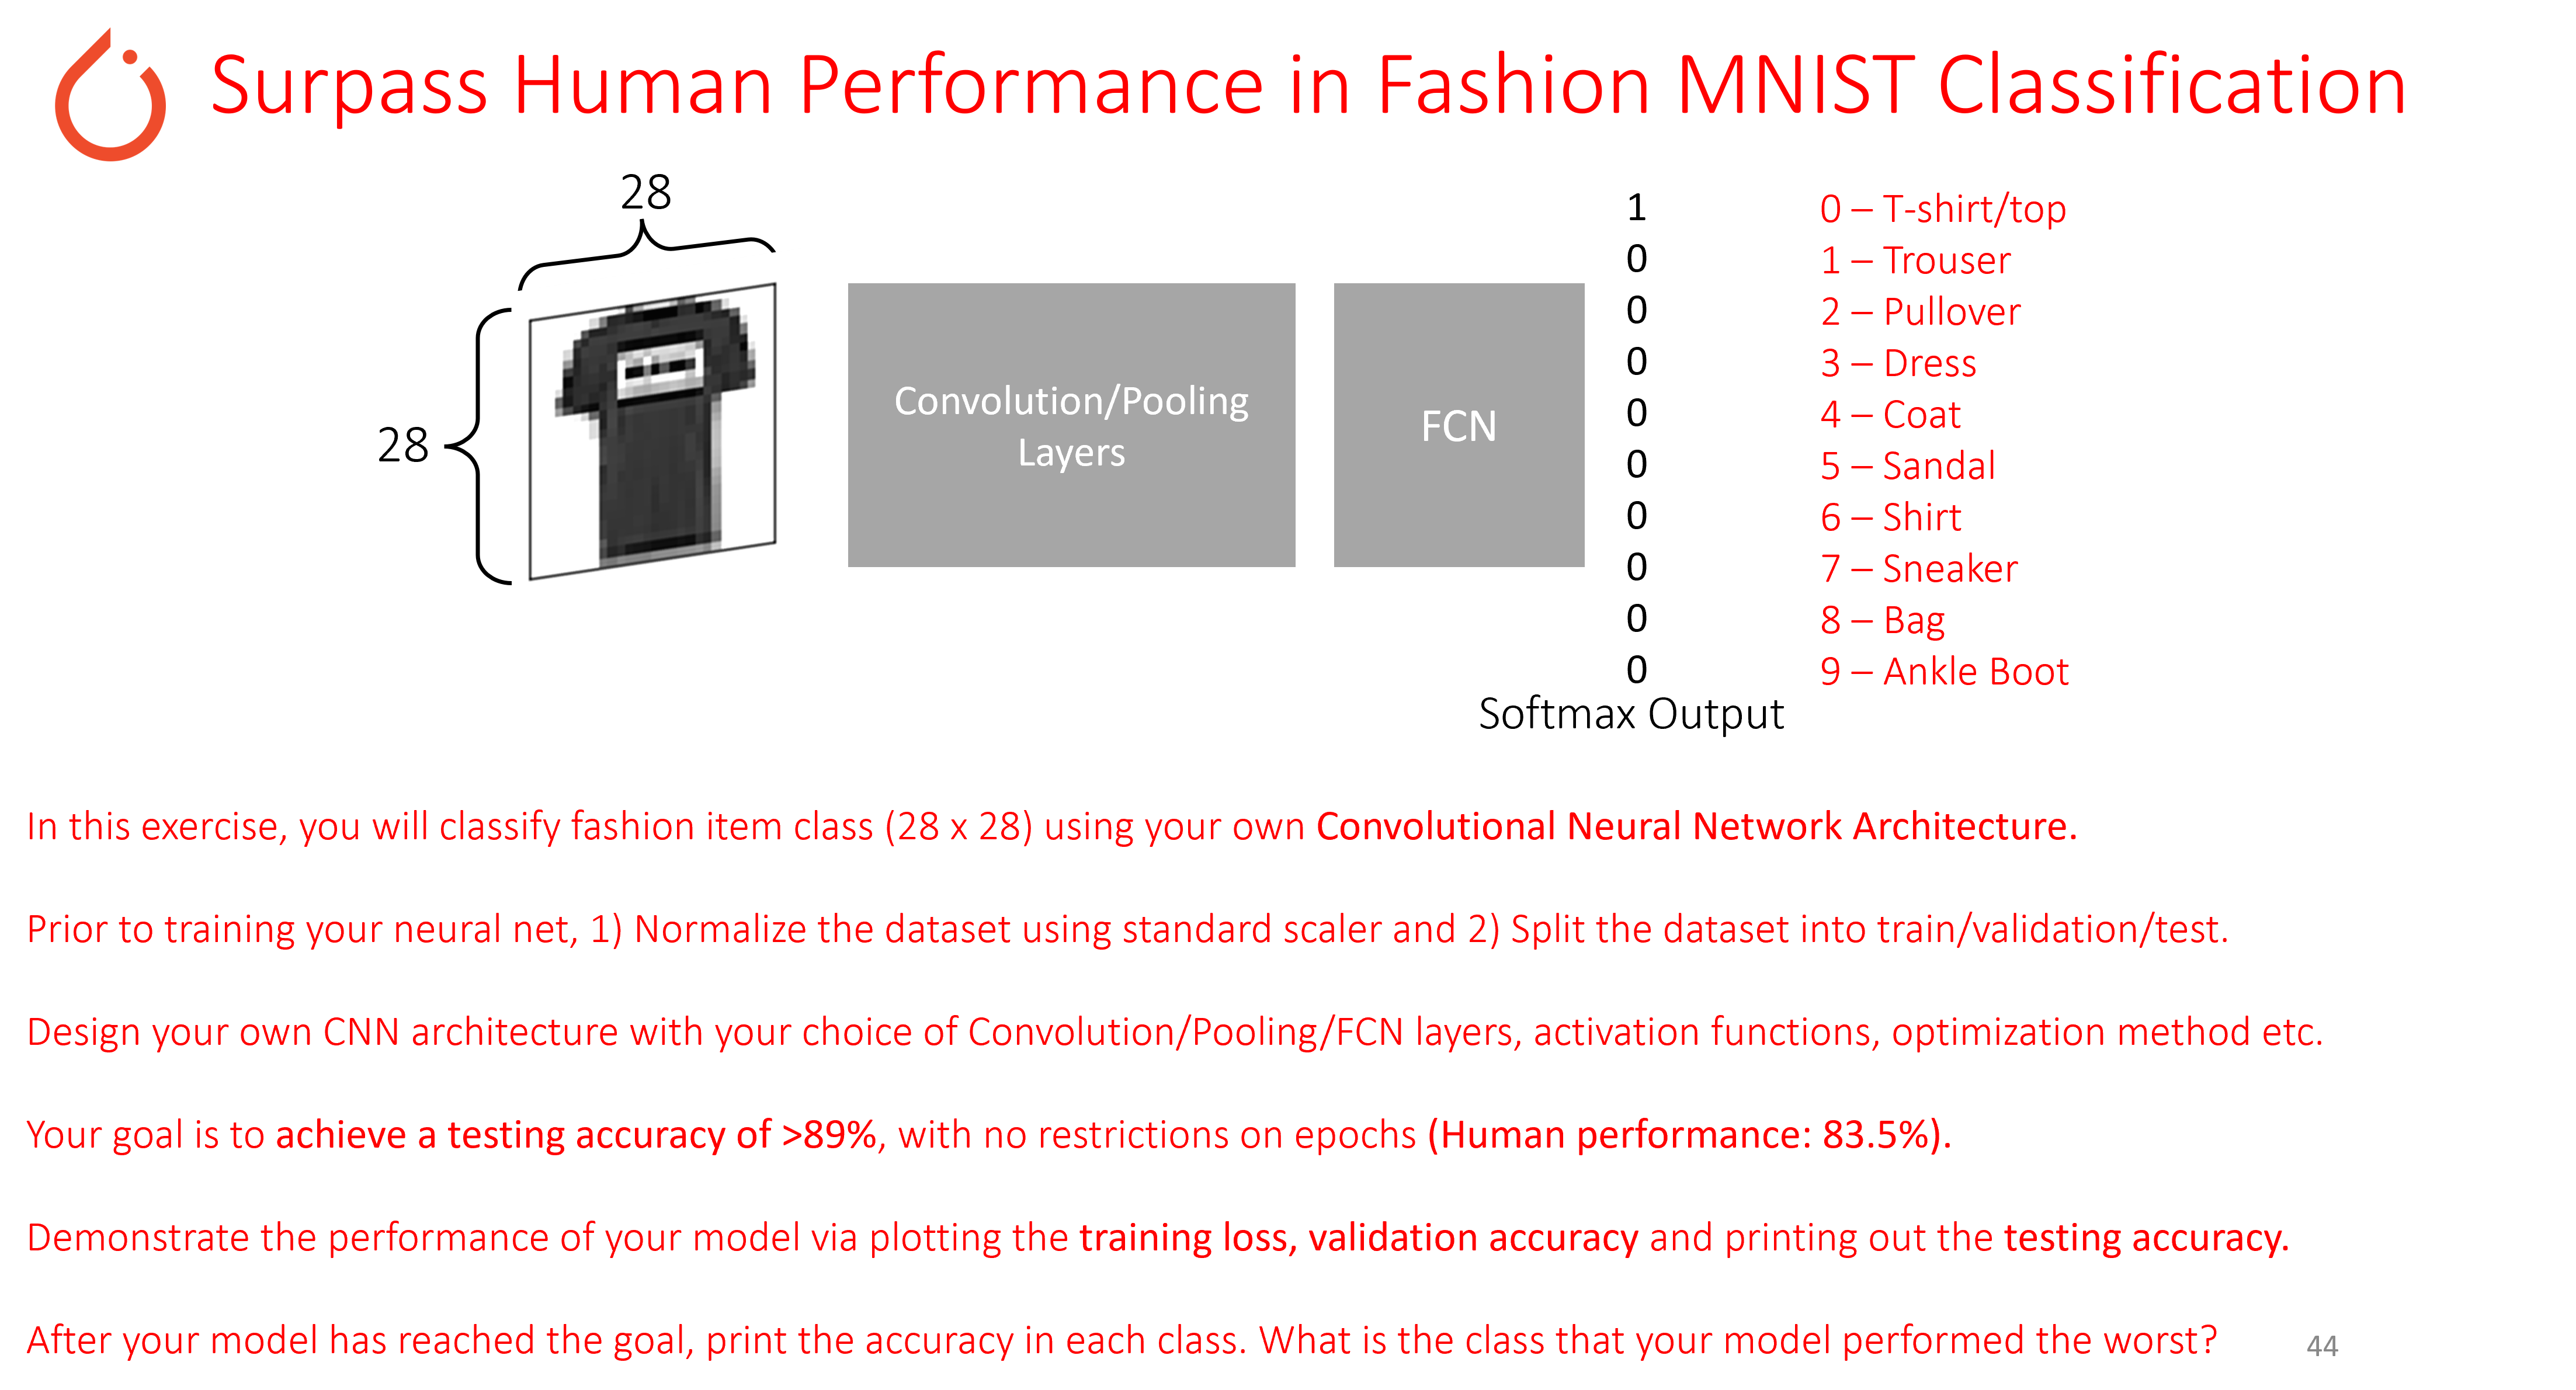

In [221]:
Image('lab4_exercise.png', width = 1000)

## Prepare Data

In [222]:
# Load Fashion-MNIST Dataset in Numpy

# 10000 training features/targets where each feature is a greyscale image with shape (28, 28)
train_features = np.load('fashion_mnist_train_features.npy') 
train_targets = np.load('fashion_mnist_train_targets.npy')

# 1000 testing features/targets 
test_features = np.load('fashion_mnist_test_features.npy')
test_targets = np.load('fashion_mnist_test_targets.npy')

# Let's see the shapes of training/testing datasets
print("Training Features Shape: ", train_features.shape)
print("Training Targets Shape: ", train_targets.shape)
print("Testing Features Shape: ", test_features.shape)
print("Testing Targets Shape: ", test_targets.shape)

Training Features Shape:  (10000, 28, 28)
Training Targets Shape:  (10000,)
Testing Features Shape:  (1000, 28, 28)
Testing Targets Shape:  (1000,)


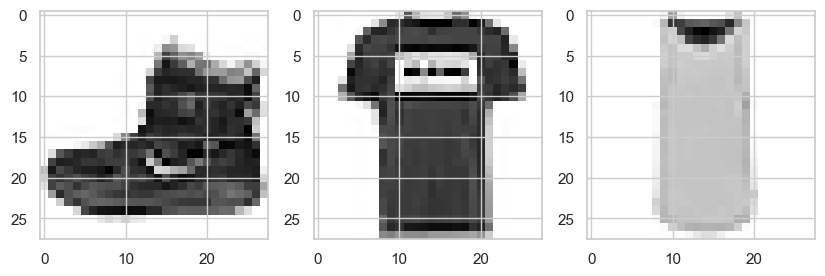

In [223]:
# Visualizing the first three training features (samples)

plt.figure(figsize = (10, 10))

plt.subplot(1,3,1)
plt.imshow(train_features[0], cmap = 'Greys')

plt.subplot(1,3,2)
plt.imshow(train_features[1], cmap = 'Greys')

plt.subplot(1,3,3)
plt.imshow(train_features[2], cmap = 'Greys')

In [224]:
# Reshape features via flattening the images
# This refers to reshape each sample from a 2d array to a 1d array.
# hint: np.reshape() function could be useful here

train_features = np.reshape(train_features, (train_features.shape[0], -1))
test_features = np.reshape(test_features, (test_features.shape[0], -1))

In [225]:
# Use the standard scaler from sklearn.preprocessing

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


# Scale the dataset according to standard scaling
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

In [226]:
# Take the first 1000 (or randomly select 1000) training features and targets as validation set 

validation_features = train_features[:1000]
validation_targets = train_targets[:1000]

# Take the remaining 9000 training features and targets as training set 

train_features = train_features[1000:]
train_targets = train_targets[1000:]

In [227]:
# Reshape train/validation/test sets to conform to PyTorch's (N, Channels, Height, Width) standard for CNNs

train_features = train_features.reshape((-1, 1, 28,28))
validation_features = validation_features.reshape((-1, 1, 28,28))
test_features = test_features.reshape((-1, 1, 28, 28))

## Define Model

In [228]:
# Define your CNN architecture here

class CNNModel(torch.nn.Module):
    
    def __init__(self):
        
        super(CNNModel, self).__init__()

        self.cnn1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2)

        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=2)

        self.cnn2 = torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=2)

        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=2)

        #fully connected layer with 800 neurons, n_channels = 28 / 2 / 2 = 7
        self.fc1 = torch.nn.Linear(32 * 7 * 7, 10)
        self.fc2 = torch.nn.Linear(10, 10)
    
    def forward(self, x):

        out = self.cnn1(x)
        out = torch.nn.functional.relu(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = torch.nn.functional.relu(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        
        return out

## Select Hyperparameters

In [229]:
# Fix the random seed so that model performance is reproducible
torch.manual_seed(96)

# Initialize your CNN model

model = CNNModel()

# Define learning rate, epoch and batchsize for mini-batch gradient

learning_rate = 0.0001
epochs = 40
batchsize = 100

# Define loss function and optimizer

loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model

CNNModel(
  (cnn1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
)

## Identify Tracked Values

In [230]:
# Placeholders for training loss and validation accuracy during training
# Training loss should be tracked for each iteration (1 iteration -> single forward pass to the network)
# Validation accuracy should be evaluated every 'Epoch' (1 epoch -> full training dataset)
# If using batch gradient, 1 iteration = 1 epoch

train_loss_list = []
validation_accuracy_list = np.zeros((epochs,))

## Train Model

In [231]:
# Convert the training, validation, testing dataset (NumPy arrays) into torch tensors

train_features = torch.from_numpy(train_features).float()
train_targets = torch.from_numpy(train_targets).long()

validation_features = torch.from_numpy(validation_features).float()
validation_targets = torch.from_numpy(validation_targets).long()

test_features = torch.from_numpy(test_features).float()
test_targets = torch.from_numpy(test_targets).long()

In [232]:
import tqdm # Use "for epoch in tqdm.trange(epochs):" to see the progress bar





# Split your training features/targets into mini-batches if using mini-batch gradient

train_batches_features = torch.split(train_features, batchsize)
train_batches_targets = torch.split(train_targets, batchsize)

# length of train_batches_features = total number of mini-batches in the training set
batch_split_num = len(train_batches_features)

# YOUR CODE HERE

# Training Loop ---------------------------------------------------------------------------------------

for epoch in range(epochs):

    for k in range(batch_split_num):
    
        optimizer.zero_grad()

        train_batch_outputs = model(train_batches_features[k])

        loss = loss_func(train_batch_outputs, train_batches_targets[k])

        train_loss_list.append(loss.item())

        loss.backward()

        optimizer.step()


    # Compute Validation Accuracy ----------------------------------------------------------------------

    with torch.no_grad():

        validation_outputs = model(validation_features)

        correct = (torch.argmax(validation_outputs, dim=1) == 
                   validation_targets).type(torch.FloatTensor)
        
        print("Epoch: "+ str(epoch), 
              "Validation Accuracy: " + str(np.round(correct.mean().numpy() * 100, 2)) + '%', flush=True)

        validation_accuracy_list[epoch] = correct.mean()


Epoch: 0 Validation Accuracy: 64.4%
Epoch: 1 Validation Accuracy: 71.4%
Epoch: 2 Validation Accuracy: 74.8%
Epoch: 3 Validation Accuracy: 77.4%
Epoch: 4 Validation Accuracy: 80.0%
Epoch: 5 Validation Accuracy: 81.2%
Epoch: 6 Validation Accuracy: 82.2%
Epoch: 7 Validation Accuracy: 83.7%
Epoch: 8 Validation Accuracy: 84.0%
Epoch: 9 Validation Accuracy: 84.2%
Epoch: 10 Validation Accuracy: 84.5%
Epoch: 11 Validation Accuracy: 85.1%
Epoch: 12 Validation Accuracy: 85.6%
Epoch: 13 Validation Accuracy: 85.7%
Epoch: 14 Validation Accuracy: 86.3%
Epoch: 15 Validation Accuracy: 86.6%
Epoch: 16 Validation Accuracy: 87.0%
Epoch: 17 Validation Accuracy: 87.0%
Epoch: 18 Validation Accuracy: 87.2%
Epoch: 19 Validation Accuracy: 87.3%
Epoch: 20 Validation Accuracy: 87.5%
Epoch: 21 Validation Accuracy: 87.5%
Epoch: 22 Validation Accuracy: 87.5%
Epoch: 23 Validation Accuracy: 87.5%
Epoch: 24 Validation Accuracy: 87.7%
Epoch: 25 Validation Accuracy: 87.9%
Epoch: 26 Validation Accuracy: 88.1%
Epoch: 27 V

## Visualize & Evaluate Model

In [233]:
# Seaborn for prettier plot

import seaborn as sns

sns.set(style = 'whitegrid', font_scale = 1)

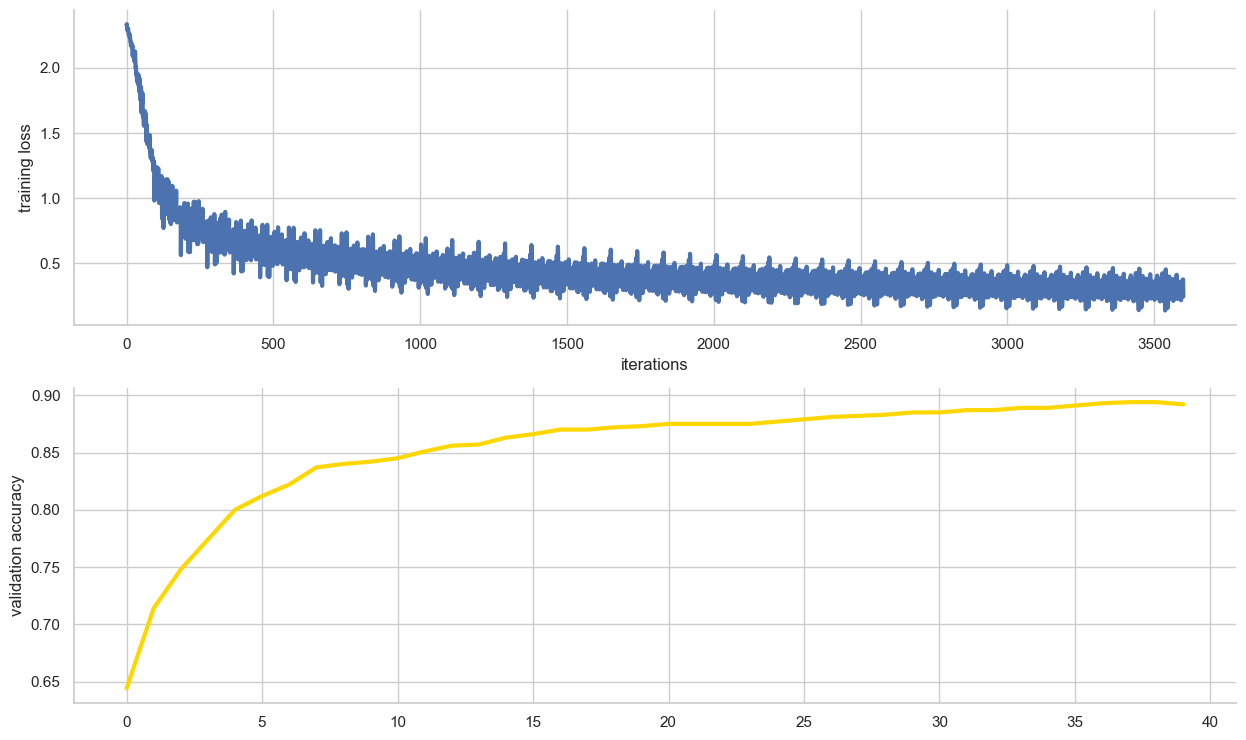

In [234]:
# Visualize training loss

plt.figure(figsize = (15, 9))

plt.subplot(2, 1, 1)
plt.plot(train_loss_list, linewidth = 3)
plt.ylabel("training loss")
plt.xlabel("iterations")
sns.despine()

plt.subplot(2, 1, 2)
plt.plot(validation_accuracy_list, linewidth = 3, color = 'gold')
plt.ylabel("validation accuracy")
sns.despine()

In [235]:
# Compute the testing accuracy 

with torch.no_grad():

    y_pred_test = model(test_features)
     
    correct = (torch.argmax(y_pred_test, dim=1) == test_targets).type(torch.FloatTensor)
    
    print("Testing Accuracy: " + str(correct.mean().numpy()))

Testing Accuracy: 0.891


In [236]:
# (OPTIONAL) Print the testing accuracy for each fashion class. Your code should produce something that looks like:
# Clever usage of np.where() could be useful here

# "Accuracy of T-shirt/top:"

y_pred_test_0 = y_pred_test[torch.where(test_targets == 0)]
correct_0 = (torch.argmax(y_pred_test_0, dim=1) == test_targets[torch.where(test_targets == 0)]).type(torch.FloatTensor)
print("Accuracy of T-shirt/top: " + str(np.round(correct_0.mean().numpy() * 100, 1)) + '%')

# "Accuracy of Trouser:"
y_pred_test_1 = y_pred_test[torch.where(test_targets == 1)]
correct_1 = (torch.argmax(y_pred_test_1, dim=1) == test_targets[torch.where(test_targets == 1)]).type(torch.FloatTensor)
print("Accuracy of Trouser: " + str(np.round(correct_1.mean().numpy() * 100, 1)) + '%')

# "Accuracy of Pullover:"
y_pred_test_2 = y_pred_test[torch.where(test_targets == 2)]
correct_2 = (torch.argmax(y_pred_test_2, dim=1) == test_targets[torch.where(test_targets == 2)]).type(torch.FloatTensor)
print("Accuracy of Pullover: " + str(np.round(correct_2.mean().numpy() * 100, 1)) + '%')

# "Accuracy of Dress:"
y_pred_test_3 = y_pred_test[torch.where(test_targets == 3)]
correct_3 = (torch.argmax(y_pred_test_3, dim=1) == test_targets[torch.where(test_targets == 3)]).type(torch.FloatTensor)
print("Accuracy of Dress: " + str(np.round(correct_3.mean().numpy() * 100, 1)) + '%')

# "Accuracy of Coat:"
y_pred_test_4 = y_pred_test[torch.where(test_targets == 4)]
correct_4 = (torch.argmax(y_pred_test_4, dim=1) == test_targets[torch.where(test_targets == 4)]).type(torch.FloatTensor)
print("Accuracy of Coat: " + str(np.round(correct_4.mean().numpy() * 100, 1)) + '%')

# "Accuracy of Sandal:"
y_pred_test_5 = y_pred_test[torch.where(test_targets == 5)]
correct_5 = (torch.argmax(y_pred_test_5, dim=1) == test_targets[torch.where(test_targets == 5)]).type(torch.FloatTensor)
print("Accuracy of Sandal: " + str(np.round(correct_5.mean().numpy() * 100, 1)) + '%')

# "Accuracy of Shirt:"
y_pred_test_6 = y_pred_test[torch.where(test_targets == 6)]
correct_6 = (torch.argmax(y_pred_test_6, dim=1) == test_targets[torch.where(test_targets == 6)]).type(torch.FloatTensor)
print("Accuracy of Shirt: " + str(np.round(correct_6.mean().numpy() * 100, 1)) + '%')

# "Accuracy of Sneaker:"
y_pred_test_7 = y_pred_test[torch.where(test_targets == 7)]
correct_7 = (torch.argmax(y_pred_test_7, dim=1) == test_targets[torch.where(test_targets == 7)]).type(torch.FloatTensor)
print("Accuracy of Sneaker: " + str(np.round(correct_7.mean().numpy() * 100, 1)) + '%')

# "Accuracy of Bag:"
y_pred_test_8 = y_pred_test[torch.where(test_targets == 8)]
correct_8 = (torch.argmax(y_pred_test_8, dim=1) == test_targets[torch.where(test_targets == 8)]).type(torch.FloatTensor)
print("Accuracy of Bag: " + str(np.round(correct_8.mean().numpy() * 100, 1)) + '%')

# "Accuracy of Ankle boot:"
y_pred_test_9 = y_pred_test[torch.where(test_targets == 9)]
correct_9 = (torch.argmax(y_pred_test_9, dim=1) == test_targets[torch.where(test_targets == 9)]).type(torch.FloatTensor)
print("Accuracy of Ankle boot: " + str(np.round(correct_9.mean().numpy() * 100, 1)) + '%')


# What's the fashion item that your model had the hardest time classifying?

correct_list = [correct_0.mean().numpy(), correct_1.mean().numpy(), correct_2.mean().numpy(), correct_3.mean().numpy(), correct_4.mean().numpy(), correct_5.mean().numpy(), correct_6.mean().numpy(), correct_7.mean().numpy(), correct_8.mean().numpy(), correct_9.mean().numpy()]

print('minimum item:', np.argmin([correct_list]),", at: ", np.min(correct_list))

Accuracy of T-shirt/top: 91.6%
Accuracy of Trouser: 98.1%
Accuracy of Pullover: 85.6%
Accuracy of Dress: 83.9%
Accuracy of Coat: 79.1%
Accuracy of Sandal: 92.0%
Accuracy of Shirt: 74.2%
Accuracy of Sneaker: 97.9%
Accuracy of Bag: 97.9%
Accuracy of Ankle boot: 92.6%
minimum item: 6 , at:  0.742268
